<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Bird_Species_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


# **1.) Data-Preprocessing**

In [ ]:
#Creating generator for Training DataSet
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        '../input/100-bird-species/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

#Creating generator for Validation DataSet
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
        '../input/100-bird-species/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

#Creating generator for Test DataSet
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        '../input/100-bird-species/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 27503 images belonging to 200 classes.
Found 1000 images belonging to 200 classes.
Found 1000 images belonging to 200 classes.


# **2.) Build and Train CNN (VGG16)** 

In [ ]:
#instantiate a base model with pre-trained weigts.
base_model=keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
#freeze the base model
base_model.trainable = False

In [ ]:
#Create new model on top
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(200,activation='softmax',kernel_initializer='glorot_normal'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)              

In [ ]:
#Train the model on new data.
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,epochs=40,validation_data=val_generator,workers=10,use_multiprocessing=True)

Epoch 1/40
430/430 [==============================] - 432s 1s/step - loss: 9.2624 - accuracy: 0.0733 - val_loss: 4.5225 - val_accuracy: 0.3290
Epoch 2/40
430/430 [==============================] - 382s 888ms/step - loss: 3.6967 - accuracy: 0.2902 - val_loss: 0.9933 - val_accuracy: 0.5950
Epoch 3/40
430/430 [==============================] - 383s 891ms/step - loss: 2.5594 - accuracy: 0.4823 - val_loss: 1.4507 - val_accuracy: 0.7640
Epoch 4/40
430/430 [==============================] - 379s 882ms/step - loss: 1.9486 - accuracy: 0.5990 - val_loss: 0.4771 - val_accuracy: 0.8220
Epoch 5/40
430/430 [==============================] - 377s 878ms/step - loss: 1.5885 - accuracy: 0.6733 - val_loss: 0.3302 - val_accuracy: 0.8510
Epoch 6/40
430/430 [==============================] - 382s 889ms/step - loss: 1.3758 - accuracy: 0.7158 - val_loss: 0.8113 - val_accuracy: 0.8800
Epoch 7/40
430/430 [==============================] - 372s 865ms/step - loss: 1.1941 - accuracy: 0.7545 - val_loss: 0.5361 - va

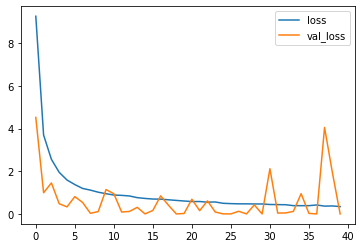

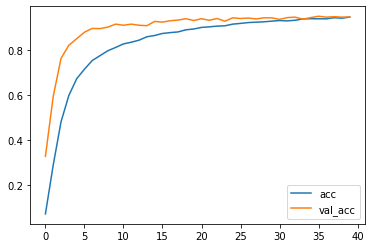

In [ ]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

# **Fine-Tuning**

In [ ]:
base_model=model.layers[0]

In [ ]:
#Un-Freezing last 2 blocks(i.e. block4 and 5)

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
base_model.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Lets fine-tune finally....
history=model.fit(train_generator,epochs=30,validation_data=val_generator,workers=10,use_multiprocessing=True)

Epoch 1/30
429/430 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9520Epoch 1/30
Epoch 1/30
430/430 [==============================] - 386s 897ms/step - loss: 0.2145 - accuracy: 0.9520 - val_loss: 0.0045 - val_accuracy: 0.9600
Epoch 2/30
430/430 [==============================] - 374s 869ms/step - loss: 0.1541 - accuracy: 0.9617 - val_loss: 3.4204e-04 - val_accuracy: 0.9530
Epoch 3/30
Epoch 2/30
430/430 [==============================] - 373s 868ms/step - loss: 0.1412 - accuracy: 0.9641 - val_loss: 5.9605e-08 - val_accuracy: 0.9590
Epoch 4/30
430/430 [==============================] - 377s 876ms/step - loss: 0.1330 - accuracy: 0.9649 - val_loss: 0.0363 - val_accuracy: 0.9550
Epoch 5/30
430/430 [==============================] - 375s 872ms/step - loss: 0.1203 - accuracy: 0.9691 - val_loss: 0.0000e+00 - val_accuracy: 0.9520
Epoch 6/30
430/430 [==============================] - 381s 885ms/step - loss: 0.1060 - accuracy: 0.9721 - val_loss: 0.0018 - val_accuracy: 0.

In [ ]:
#few more epochs with low l_rate
model.compile(optimizer=keras.optimizers.Adam(1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,epochs=10,validation_data=val_generator,workers=10,use_multiprocessing=True)

Epoch 1/10
430/430 [==============================] - 407s 947ms/step - loss: 0.0396 - accuracy: 0.9889 - val_loss: 0.5046 - val_accuracy: 0.9640
Epoch 2/10
430/430 [==============================] - 398s 925ms/step - loss: 0.0334 - accuracy: 0.9901 - val_loss: 0.0027 - val_accuracy: 0.9650
Epoch 3/10
430/430 [==============================] - 397s 924ms/step - loss: 0.0369 - accuracy: 0.9893 - val_loss: 1.5199e-06 - val_accuracy: 0.9650
Epoch 4/10
430/430 [==============================] - 386s 898ms/step - loss: 0.0347 - accuracy: 0.9900 - val_loss: 6.4520e-06 - val_accuracy: 0.9660
Epoch 5/10
430/430 [==============================] - 386s 898ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0000e+00 - val_accuracy: 0.9610
Epoch 6/10
430/430 [==============================] - 393s 913ms/step - loss: 0.0339 - accuracy: 0.9904 - val_loss: 0.0015 - val_accuracy: 0.9630
Epoch 7/10
430/430 [==============================] - 400s 930ms/step - loss: 0.0304 - accuracy: 0.9911 - val_lo

In [ ]:
model.save("model_fine_tuned")

# 3.) Evaluation on Test Set

In [ ]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

32/32 [==============================] - 6s 187ms/step


[1.349977628706256e-05, 0.9909999966621399]